In [1]:
import json
import os

from cycler import cycler

import arviz as az
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib as mpl

from matplotlib import pyplot as plt
from pprint import pprint
from sphincter.data_preparation import load_prepared_data
from sphincter.plotting import plot_obs, plot_predictive, save_figure

INFERENCES_DIR = os.path.join("..", "inferences")
PLOTS_DIR = os.path.join("..", "plots")
CMAP = plt.get_cmap('Set2')

plt.rcParams['axes.prop_cycle'] = cycler(color=CMAP.colors)
az.rcParams['data.load'] = "eager"

In [2]:
prepared_data = load_prepared_data("../data/prepared/pressure.json")
msts = prepared_data.measurements
msts.head()

/Users/tedgro/repos/teddygroves/sphincter/.venv/lib/python3.13/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


,mouse,age,treatment,map,pp,hr
0,11020,adult,ablation,48.490100,10.969394,5.112988
1,11020,adult,after_hyper1,50.055069,12.031981,5.178857
2,11020,adult,baseline,60.587775,12.960534,5.155377
3,11020,adult,hyper1,96.987509,13.702829,5.800671
4,11020,adult,hyper2,92.368492,8.044521,5.777388


In [3]:
print(msts.groupby(["age", "treatment"])["mouse"].nunique().unstack("age").to_markdown())

| treatment    |   adult |   old |
|:-------------|--------:|------:|
| baseline     |      14 |    12 |
| hyper1       |      10 |    11 |
| after_hyper1 |      22 |    13 |
| ablation     |      21 |    13 |
| hyper2       |      13 |    11 |


/var/folders/ql/z_6fb5792v1_8tscf4hg5byc0000gp/T/ipykernel_97206/2928514429.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(msts.groupby(["age", "treatment"])["mouse"].nunique().unstack("age").to_markdown())


In [4]:
idata = az.InferenceData.from_zarr(os.path.join(INFERENCES_DIR, "pressure", "idata"))

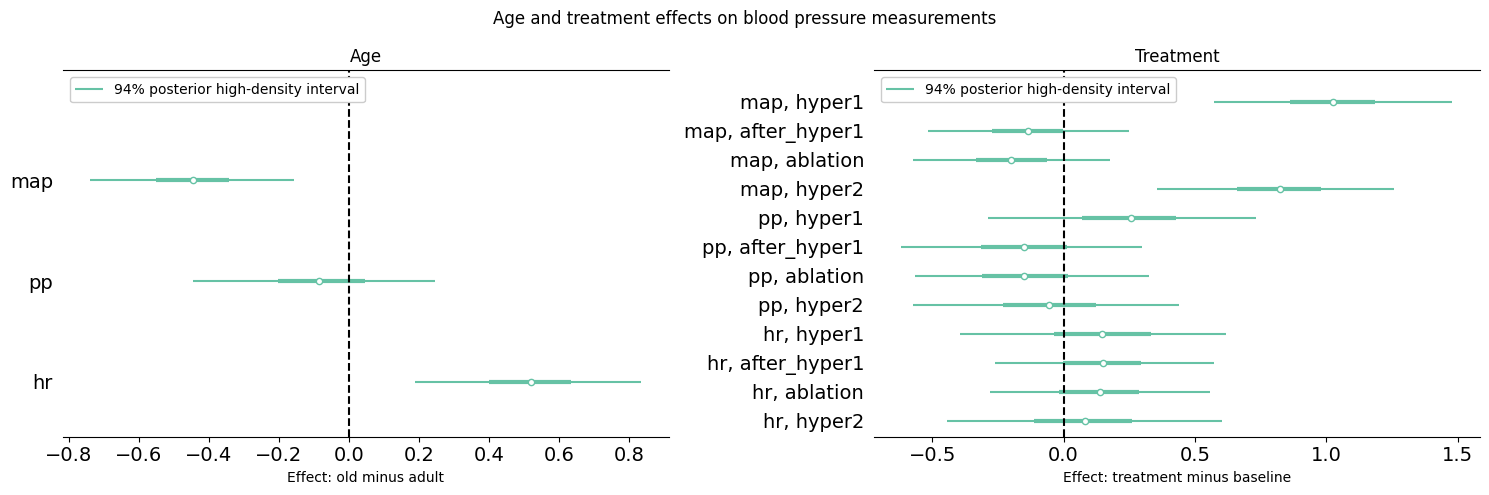

In [5]:
f, axes = plt.subplots(1, 2, figsize=[15, 5])

vcb = [
    ("a_age", "age", "adult"),
    ("a_treatment", "treatment", "baseline")
]

for (var, coord, baseline), ax in zip(vcb, axes):
    t = (
        idata.posterior[var] - idata.posterior[var].sel(**{coord: baseline})
    ).sel(**{coord: [c for c in idata.posterior.coords[coord].to_numpy() if c != baseline]})
    az.plot_forest(t, combined=True, ax=ax, labeller=az.labels.NoVarLabeller())
    ax.set(title=coord.capitalize())
    ax.axvline(0.0, linestyle="--", color="black")
    ax.legend([ax.collections[0]], ["94% posterior high-density interval"], framealpha=1.0, loc="upper left")
axes[0].set(xlabel="Effect: old minus adult") 
axes[1].set(xlabel="Effect: treatment minus baseline")
f.suptitle("Age and treatment effects on blood pressure measurements")
f.tight_layout()
save_figure(f, "pressure-results")

In [6]:
{coord: c for c in list(idata.posterior.coords[coord].to_numpy())}

{'treatment': 'hyper2'}

In [7]:
list(idata.posterior.coords[coord].to_numpy())

['baseline', 'hyper1', 'after_hyper1', 'ablation', 'hyper2']

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

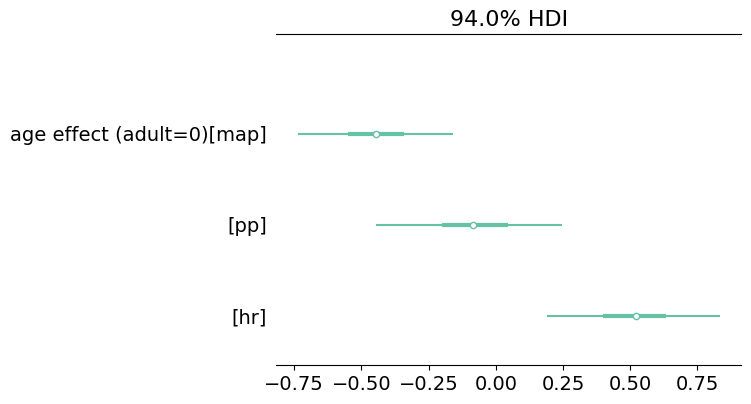

In [8]:
t = (
    idata.posterior["a_age"] - idata.posterior["a_age"].sel(age="adult")
).rename("age effect (adult=0)")


az.plot_forest(t, combined=True, coords={"age": ["old"]})

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

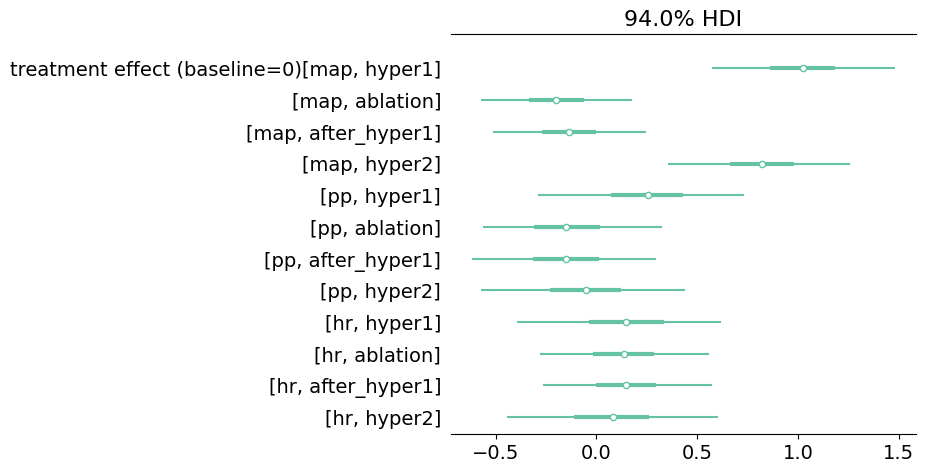

In [9]:
t = (
    idata.posterior["a_treatment"]
    - idata.posterior["a_treatment"].sel(treatment="baseline")
).rename("treatment effect (baseline=0)")

az.plot_forest(t, combined=True, coords={"treatment": ["hyper1", "ablation", "after_hyper1", "hyper2"]})

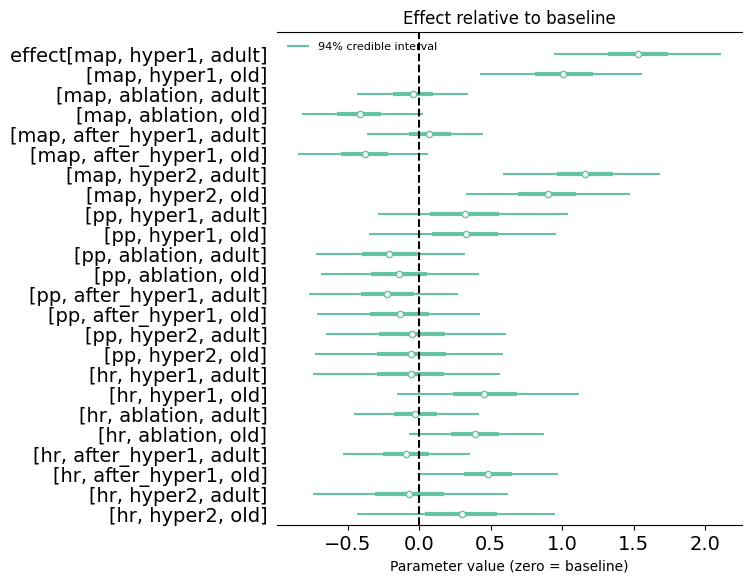

In [10]:
t = (
    idata.posterior["a_age"]
    + (idata.posterior["a_treatment"] - idata.posterior["a_treatment"].sel(treatment="baseline")) 
    + (idata.posterior["a_age_treatment"] - idata.posterior["a_age_treatment"].sel(treatment="baseline"))
).transpose(*["chain", "draw", "measurement_type", "treatment", "age"]).rename("effect")

az.plot_forest(
    t, 
    combined=True,
    coords={"treatment": ["hyper1", "ablation", "after_hyper1", "hyper2"]},
    legend=True
    
)
f = plt.gcf()
ax = plt.gca()
ax.axvline(0, linestyle="--", color="black")
ax.legend([ax.collections[0]], ["94% credible interval"], frameon=False, loc="upper left", fontsize=8)
ax.set(title="Effect relative to baseline", xlabel="Parameter value (zero = baseline)");

In [11]:
age_diff = t.sel(age="adult") - t.sel(age="old")
(age_diff.sel(measurement_type="hr", treatment="hyper2") > 0).to_numpy().mean()

0.187

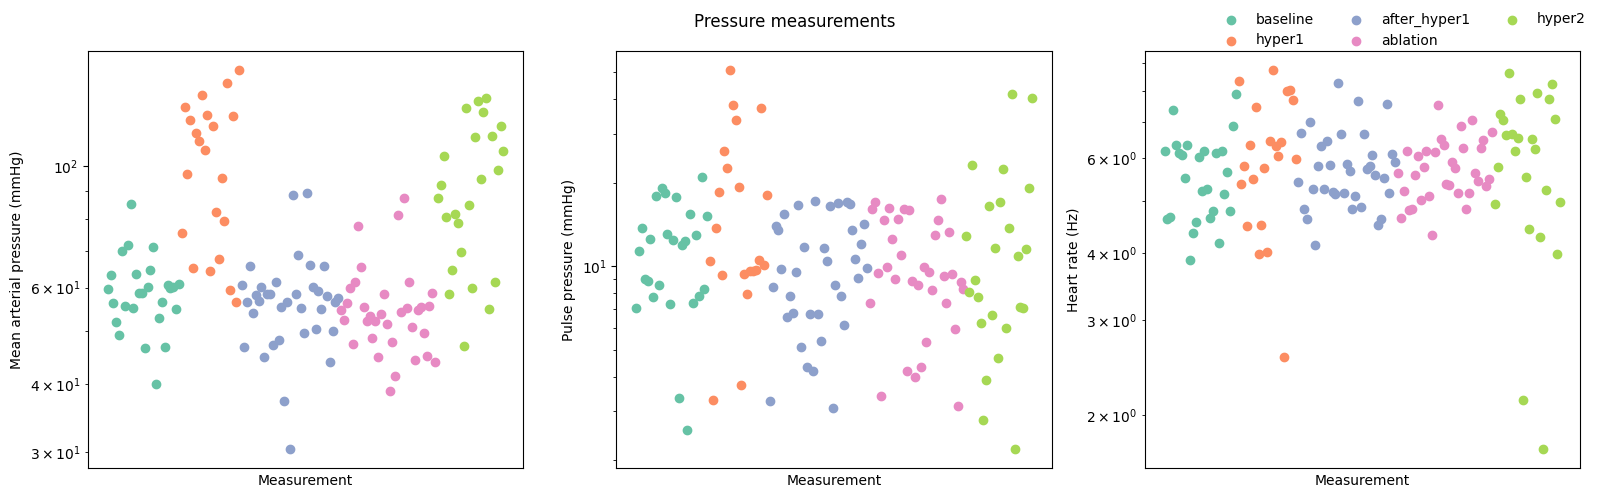

In [12]:
f, axes = plt.subplots(1, 3, figsize=[16, 5])

ylabels = [
    "Mean arterial pressure (mmHg)",
    "Pulse pressure (mmHg)",
    "Heart rate (Hz)"
]

for col, ax, ylabel in zip(["map", "pp", "hr"], axes, ylabels):
    plot_obs(ax, msts[col], cat=msts["treatment"]);
    ax.set(ylabel=ylabel, xlabel="Measurement")
    ax.set_xticks([])
    h, l = ax.get_legend_handles_labels()
    ax.semilogy()
f.suptitle("Pressure measurements");
f.legend(h, l, frameon=False, ncol=3);
f.tight_layout()
save_figure(f, "pressure-data")

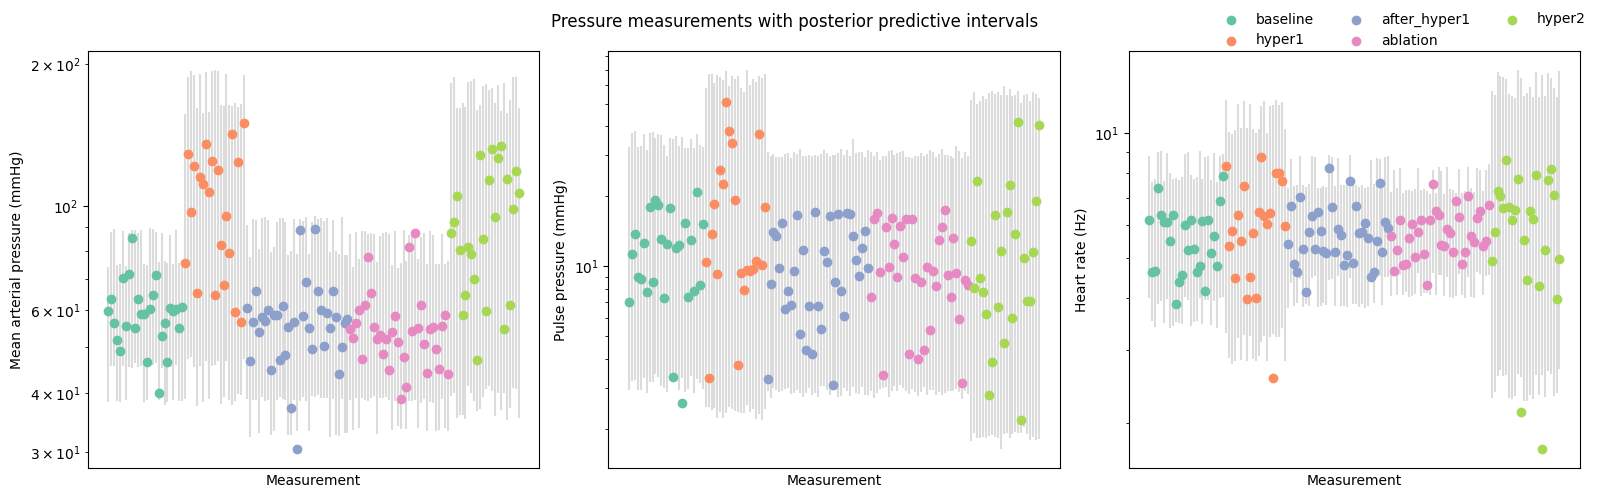

In [13]:
f, axes = plt.subplots(1, 3, figsize=[16, 5])

ylabels = [
    "Mean arterial pressure (mmHg)",
    "Pulse pressure (mmHg)",
    "Heart rate (Hz)"
]
yrep = idata.posterior_predictive["yrep"]

for col, ax, ylabel in zip(["map", "pp", "hr"], axes, ylabels):
    plot_obs(ax, msts[col], cat=msts["treatment"]);
    plot_predictive(ax, yrep.sel(measurement_type=col), zorder=-1, cat=msts["treatment"])
    ax.set(ylabel=ylabel, xlabel="Measurement")
    ax.set_xticks([])
    h, l = ax.get_legend_handles_labels()
    ax.semilogy()
f.suptitle("Pressure measurements with posterior predictive intervals");
f.legend(h, l, frameon=False, ncol=3);
f.tight_layout()
save_figure(f, "pressure-ppc")

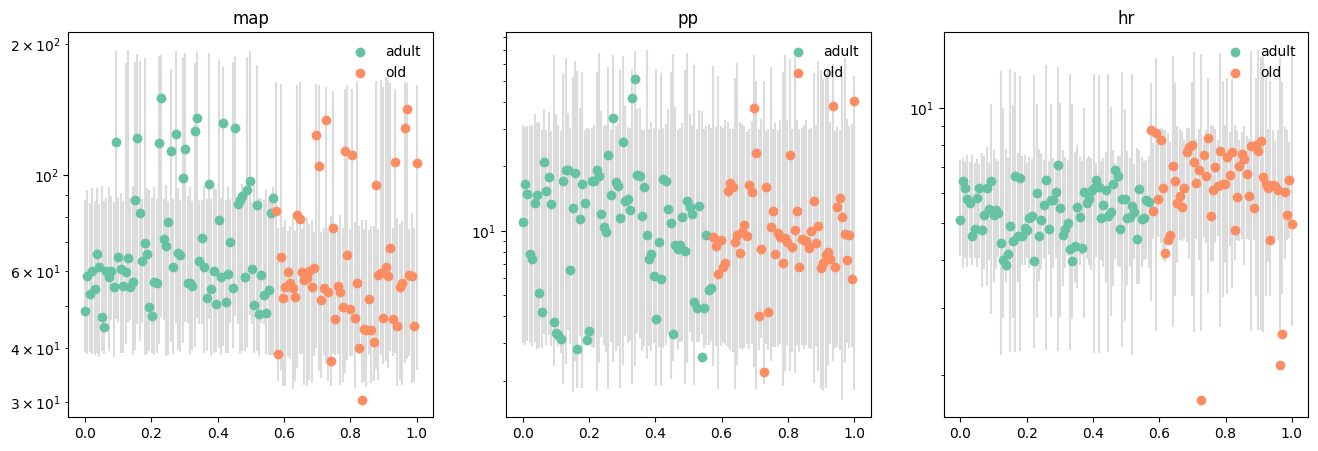

In [14]:
yrep = idata.posterior_predictive["yrep"]

f, axes = plt.subplots(1, 3, figsize=[16, 5])

for col, ax in zip(["map", "pp", "hr"], axes):
    plot_obs(ax, msts[col], cat=msts["age"]);
    plot_predictive(ax, yrep.sel(measurement_type=col), zorder=-1, cat=msts["age"])
    ax.legend(frameon=False)
    ax.set(title=col)
    ax.semilogy()